# 1. Imports & Setup

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Import Data

In [ ]:
# Load processed data
sentiment_df = pd.read_csv('./Processed Data/sentiment_reviews_18oct.csv')
print(sentiment_df.head())
#print rows
print(sentiment_df.shape)

game_df = pd.read_csv('./Processed Data/games.csv')
print(game_df.head())


   reviewid           playerid   gameid  \
0    639544  76561198028706627   393380   
1    639547  76561198272817436      730   
2    639571  76561198111259840  1476680   
3    639583  76561198164012532   244210   
4    639671  76561198979874677   739630   

                                              review  helpful  funny  awards  \
0  ---{ Graphics }---☐ You forget what reality is...        0      0       0   
1                    ONE OF THE GAMES I COME BACK TO        2      0       0   
2  I love this game!Of course it is currently in ...        5      0       1   
3  only purchase if using a sim wheel setup with ...        0      0       0   
4  Fun game and the community is great ive made t...        2      0       0   

       posted language  sentiment_score  
0  2025-01-03       en         5.000000  
1  2020-01-23       en         3.049362  
2  2022-09-23       en         4.779496  
3  2021-09-17       en         4.823064  
4  2020-11-27       en         5.000000  
(303871,

# 2. Sanity Check

## Duplicate Check

Initial check confirmed that there are no duplicate reviews, meaning no single player submitted more than one review for the same game.


In [9]:
# Count the number of reviews per player for each game
review_counts = sentiment_df.groupby(['playerid', 'gameid']).size().reset_index(name='num_reviews')

# Filter to find instances where a player has more than one review (duplicates)
multiple_reviews = review_counts[review_counts['num_reviews'] > 1]

if multiple_reviews.empty:
    print("No instances found where a player gave multiple reviews for the same game.")
else:
    print(multiple_reviews)

No instances found where a player gave multiple reviews for the same game.


## Plotting of sentiment distribution

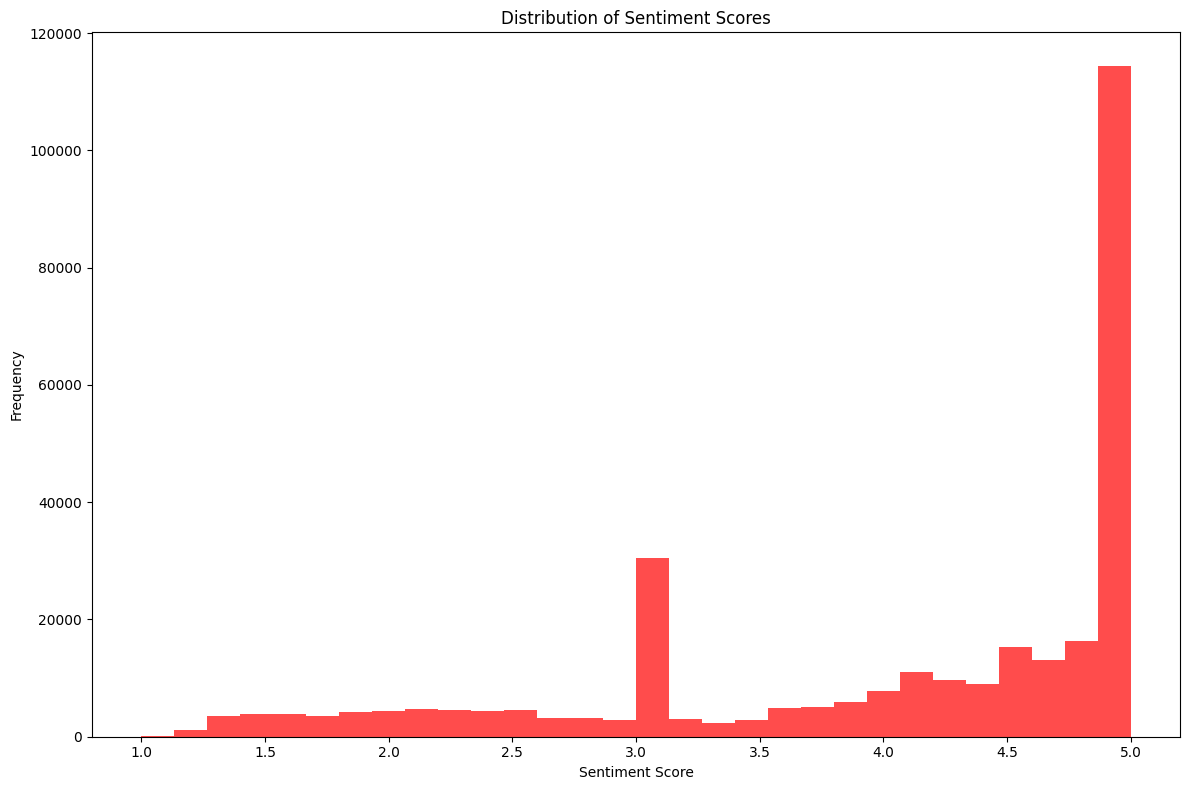

In [12]:
#visualise plot for sentiment_score
plt.figure(figsize=(12, 8))
plt.hist(sentiment_df['sentiment_score'], bins=30, color='red', alpha=0.7)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Adjustment of sentiment scores
Clipping scores and changing them from 1-5 to 0-1 to prevent bias in wieghting.

In [13]:
#drop NA sentiment scores
sentiment_df = sentiment_df.dropna(subset=['sentiment_score'])
#Clip sentiment scores to be within 1.0 to 5.0 then range from 0 to 1
sentiment_df["sentiment_score"] = sentiment_df["sentiment_score"].clip(1.0, 5.0)
sentiment_df["sentiment_score_01"]   = (sentiment_df["sentiment_score"] - 1.0) / 4.0


# 3. Data Preprocessing

Using LabelEncoder to encode userId and gameId and Splitting Data into Train and Test Sets

In [27]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
sentiment_df['player'] = user_encoder.fit_transform(sentiment_df['playerid'])
sentiment_df['game'] = item_encoder.fit_transform(sentiment_df['gameid'])


## Dataset Sparsity () counts-only
U,I = sentiment_df['player'].nunique(), sentiment_df['game'].nunique()
N = len(sentiment_df)
sparsity = 1 - (N / (U * I))


def find_col(df, options):
    for col in df.columns:
        if col in options: return col
    raise ValueError("cannot find column")

#split dataset
train_df, test_df = train_test_split(sentiment_df, test_size=0.2, random_state=4222)


print(f"Players (U): {U}")
print(f"Games (I): {I}")
print(f"Interactions (N): {N}")
print(f"Data Sparsity: {sparsity*100:.2f}%")
print("Training set length:", len(train_df))
print("Testing set length:", len(test_df))
num_players = sentiment_df['playerid'].nunique()
num_games = sentiment_df['gameid'].nunique()


Players (U): 65657
Games (I): 28234
Interactions (N): 303871
Data Sparsity: 99.98%
Training set length: 243096
Testing set length: 60775


### NCFModel: Neural Collaborative Filtering

This code defines a neural network model for collaborative filtering, using embeddings for players and games. It includes three fully connected layers with batch normalization, ReLU activations, and dropout for regularization. The model ends with a linear output layer for predicting the rating. Custom weight initialization is applied using Kaiming He initialization for linear layers and normal distribution for embedding layers.

Key layers:
- Embedding layers for players and games
- Three fully connected layers with batch normalization, ReLU, and dropout
- Custom weight initialization for better convergence


In [17]:

class NCFModel(nn.Module):
    def __init__(self, num_players, num_games, embedding_dim=32, dropout_rate=0.3):
        super(NCFModel, self).__init__()
        
        # --- Embedding Layers ---
        self.player_embedding = nn.Embedding(num_players, embedding_dim)
        self.game_embedding = nn.Embedding(num_games, embedding_dim)
        

        
        # Layer 1
        self.fc1 = nn.Linear(embedding_dim * 2, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Layer 2 (The new layer)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3 (Was your old fc2)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # --- Output Layer ---
        self.output_layer = nn.Linear(64, 1)
        
        # --- Custom Weight Initialization (Tweak) ---
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Custom function to initialize weights.
        This is a common tweak for better convergence.
        """
        if isinstance(module, nn.Embedding):
            # Initialize embeddings with a small-variance normal distribution
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.Linear):
            # Use Kaiming He initialization for layers followed by ReLU
            nn.init.kaiming_normal_(module.weight.data, a=0.01)
            if module.bias is not None:
                # Initialize biases to zero
                nn.init.constant_(module.bias.data, 0)

    def forward(self, player, game):
        # Embeddings
        player_emb = self.player_embedding(player)
        game_emb = self.game_embedding(game)
        
        # Concatenate embeddings
        x = torch.cat([player_emb, game_emb], dim=-1)
        
        # Pass through MLP tower
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x) # Apply BatchNorm *before* activation
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Layer 2 (New)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        # Output
        logits = self.output_layer(x)
        
        return logits
        
      

# Steam Dataset Loader

This code defines a custom dataset class for loading Steam game review data, converting user, game, and sentiment columns into tensors. 


In [18]:
class SteamDatasetNonBinary(Dataset):
    def __init__(self, dataframe):
        # Convert columns to tensors
        self.users = torch.tensor(dataframe["player"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["game"].values, dtype=torch.long)
        #utilised 1to5 sentiment labels
        self.labels = torch.tensor(dataframe["sentiment_score_01"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


train_dataset = SteamDatasetNonBinary(train_df)
test_dataset = SteamDatasetNonBinary(test_df)
train_loader_nonbinary = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_nonbinary = DataLoader(test_dataset, batch_size=128, shuffle=False)



# Neural Collaborative Filtering Training and Evaluation

This code trains a Neural Collaborative Filtering (NCF) model and evaluates it using multiple metrics, including RMSE, NDCG@10, and MAE. The model is optimized using the Adam optimizer with learning rate scheduling based on validation loss. The evaluation function computes the following:

- **RMSE (Root Mean Square Error)**: Measures the difference between predicted and actual ratings.
- **NDCG@10**: Normalized Discounted Cumulative Gain at rank 10, used for ranking evaluation.
- **MAE (Mean Absolute Error)**: Measures the average absolute difference between predicted and actual ratings.

Key steps include:
1. Training the model for a specified number of epochs (`EPOCHS`), updating weights with backpropagation.
2. Evaluating model performance on the validation set using the `evaluation_metrics` function.
3. Adjusting the learning rate using `ReduceLROnPlateau` if validation loss plateaus.

The training and validation losses are plotted for comparison over the epochs.

### Key Functions:
- `ndcg_at_k()`: Calculates NDCG for top-k ranking.
- `evaluation_metrics()`: Computes the RMSE, NDCG@10, MAE, and average validation loss.


Epoch 1 | Train Loss: 0.19258 | Val Loss: 0.08146 | RMSE: 0.28541 | NDCG@10: 0.97596 | MAE: 0.25082
Epoch 2 | Train Loss: 0.07888 | Val Loss: 0.07318 | RMSE: 0.27052 | NDCG@10: 0.97745 | MAE: 0.22997
Epoch 3 | Train Loss: 0.06799 | Val Loss: 0.07170 | RMSE: 0.26776 | NDCG@10: 0.97804 | MAE: 0.21865
Epoch 4 | Train Loss: 0.05997 | Val Loss: 0.07361 | RMSE: 0.27132 | NDCG@10: 0.97790 | MAE: 0.21981
Epoch 5 | Train Loss: 0.05406 | Val Loss: 0.07548 | RMSE: 0.27473 | NDCG@10: 0.97730 | MAE: 0.21880
Epoch 6 | Train Loss: 0.04735 | Val Loss: 0.08022 | RMSE: 0.28323 | NDCG@10: 0.97700 | MAE: 0.21863
Epoch 7 | Train Loss: 0.03680 | Val Loss: 0.08265 | RMSE: 0.28750 | NDCG@10: 0.97686 | MAE: 0.21843
Epoch 8 | Train Loss: 0.03401 | Val Loss: 0.08465 | RMSE: 0.29094 | NDCG@10: 0.97679 | MAE: 0.21871
Epoch 9 | Train Loss: 0.03221 | Val Loss: 0.08599 | RMSE: 0.29324 | NDCG@10: 0.97689 | MAE: 0.22246
Epoch 10 | Train Loss: 0.03035 | Val Loss: 0.08640 | RMSE: 0.29393 | NDCG@10: 0.97686 | MAE: 0.21988

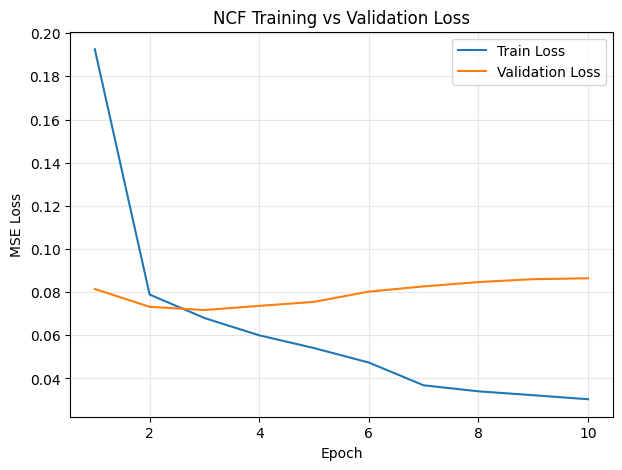

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

model = NCFModel(num_players, num_games, embedding_dim=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimiser = optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=2)
EPOCHS = 10

def evaluation_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels, all_users = [], [], []
    total_val_loss, val_batches = 0.0, 0
    with torch.no_grad():
        for users, items, labels in loader:
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)

            preds = model(users, items).squeeze(1)
            loss = criterion(preds, labels)
            total_val_loss += loss.item()
            val_batches += 1

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_users.append(users.cpu().numpy())

    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels)
    users = np.concatenate(all_users)

    rmse = np.sqrt(np.mean((preds - labels) ** 2))


    ndcgs = []
    user_to_idx = {}
    for i, u in enumerate(users):
        if int(u) not in user_to_idx:
            user_to_idx[int(u)] = []
        user_to_idx[int(u)].append(i)

    for u, idxs in user_to_idx.items():
        scores_u = preds[idxs]
        labels_u = labels[idxs]
        order = np.argsort(-scores_u)  
        ranked_relevances = labels_u[order]
        ndcgs.append(ndcg_at_k(ranked_relevances, 10))

    ndcg10 = float(np.mean(ndcgs)) if len(ndcgs) > 0 else 0.0

    # Mean Absolute Error
    mae = np.mean(np.abs(preds - labels))

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    return avg_val_loss, rmse, ndcg10, mae


train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_train_loss, train_batches = 0.0, 0

    for users, items, labels in train_loader_nonbinary:
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()
        preds = model(users, items).squeeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimiser.step()

        running_train_loss += loss.item()
        train_batches += 1

    avg_train_loss = running_train_loss / max(train_batches, 1)
    train_losses.append(avg_train_loss)

    #eval
    val_loss, rmse, ndcg10, mae = evaluation_metrics(model, test_loader_nonbinary, device)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch} | "
          f"Train Loss: {avg_train_loss:.5f} | "
          f"Val Loss: {val_loss:.5f} | "
          f"RMSE: {rmse:.5f} | "
          f"NDCG@10: {ndcg10:.5f} | "
          f"MAE: {mae:.5f}")

plt.figure(figsize=(7,5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.title("NCF Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




# Export recommendations for all relevant players

# Code to Prepare for Interaction Data

This code snippet prepares data for a collaborative filtering model by combining training and testing datasets, building a map of seen game IDs for each player, and collecting all possible game IDs.

### Steps:
1. **Combine Train and Test Data**: Concatenates the training and test DataFrames into one combined dataset (`all_df`).
2. **Seen Items Map**: Creates a dictionary (`seen_items_by_user`) where each player's ID maps to a set of game IDs they have interacted with, using `groupby` on the `player` column.
3. **All Game IDs**: Generates a set of all possible game IDs assuming they are 0-indexed.

### Purpose:
- This prepares the data for filtering interactions, making it easier to track which games each user has seen, and which games are available to recommend.


In [20]:
# 1. Combine train and test to get all known interactions
all_df = pd.concat([train_df, test_df])

# 2. Create a map of {player_id: {game_id_1, game_id_2, ...}}
print("Building seen items map...")
seen_items_by_user = all_df.groupby('player')['game'].apply(set).to_dict()

# 3. Get the set of all possible game IDs (assuming they are 0-indexed)
all_game_ids = set(range(num_games))
print("Preparation complete.")

Building seen items map...
Preparation complete.


In [21]:
def get_top_k_recommendations(user_id, model, device, k=10, 
                              all_game_ids_set=all_game_ids, 
                              seen_items_map=seen_items_by_user, 
                              batch_size=1024):
    
    model.eval()
    seen_items = seen_items_map.get(user_id, set())
    unseen_items = list(all_game_ids_set - seen_items)
    
    if not unseen_items:
        print(f"User {user_id} has seen all items. No recommendations.")
        return []

    all_preds = []
    
    with torch.no_grad():
        for i in range(0, len(unseen_items), batch_size):
            batch_item_ids = unseen_items[i : i + batch_size]
            batch_user_tensor = torch.tensor(
                [user_id] * len(batch_item_ids), 
                dtype=torch.long
            ).to(device)
            batch_item_tensor = torch.tensor(
                batch_item_ids, 
                dtype=torch.long
            ).to(device)
            batch_preds = model(batch_user_tensor, batch_item_tensor).squeeze(1)
            all_preds.append(batch_preds.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    

    score_pairs = list(zip(all_preds, unseen_items))
    

    score_pairs.sort(key=lambda x: x[0], reverse=True)
    
    # 8. Get the item IDs from the top K pairs
    top_k_recs = [item_id for score, item_id in score_pairs[:k]]
    
    return top_k_recs

# Get Top-K Recommendations for a User

This function generates the top K recommendations for a given user by predicting ratings for unseen items using the trained model.

### Steps:
1. **Input Parameters**:
   - `user_id`: The ID of the user for whom recommendations are being generated.
   - `model`: The trained collaborative filtering model.
   - `device`: The device (CPU or GPU) to run the model on.
   - `k`: The number of recommendations to return (default is 10).
   - `all_game_ids_set`: A set of all possible game IDs.
   - `seen_items_map`: A dictionary mapping users to the games they've already interacted with.
   - `batch_size`: The number of items to process in each batch (default is 1024).
   
2. **Get Unseen Items**: Finds the set of items the user has not interacted with.
3. **Prediction**: For each batch of unseen items, the model predicts the ratings, which are collected and sorted in descending order.
4. **Top-K Recommendations**: The function returns the IDs of the top `k` items based on predicted scores.

### Key Features:
- Efficient batching for large numbers of items.
- Ensures that recommendations are based on unseen items only.
- Uses the model's predictions to rank items for the user.


In [22]:

from tqdm import tqdm

# Get a list of all unique players
all_relevant_players = list(seen_items_by_user.keys())
print(f"Generating recommendations for {len(all_relevant_players)} players...")

# This dictionary will hold all results
all_recommendations = {}

# Loop with a progress bar
for user_id in tqdm(all_relevant_players):
    recs = get_top_k_recommendations(
        user_id=user_id,
        model=model,
        device=device,
        k=10,
        all_game_ids_set=all_game_ids,
        seen_items_map=seen_items_by_user
    )
    all_recommendations[user_id] = recs

print("\nRecommendation generation complete.")
# You can now inspect the 'all_recommendations' dictionary
# print(all_recommendations[target_player_id])

Generating recommendations for 65657 players...


100%|██████████| 65657/65657 [55:27<00:00, 19.73it/s]  


Recommendation generation complete.


save to csv

In [24]:
#output to csv
recommendations_list = []
for user_id, recs in all_recommendations.items():
    for rank, game_id in enumerate(recs, start=1):
        recommendations_list.append({
            "user_id": user_id,
            "game_id": game_id,
            "rank": rank
        })
recommendations_df = pd.DataFrame(recommendations_list)
recommendations_df.to_csv('collaborative_filtering_recommendations.csv', index=False)
print("Recommendations saved to 'collaborative_filtering_recommendations.csv'.")

Recommendations saved to 'collaborative_filtering_recommendations.csv'.


### Generating a Map from Encoded Game IDs to Titles

This code creates a mapping from encoded game IDs (used in the model) to map the titles of the games for better interpretability of recommendations.

In [55]:

original_to_title_map = pd.Series(game_df.title.values, index=game_df.gameid).to_dict()

encoded_id_to_title = {}
for encoded_id, original_id in enumerate(item_encoder.classes_):
    
    # Use the original_id to find the title in our first map
    title = original_to_title_map.get(original_id, f"Unknown Game ID: {original_id}")
    
    # Store it in our new map
    encoded_id_to_title[encoded_id] = title

print(f"Created a new map from {len(encoded_id_to_title)} encoded IDs to titles.")



Created a new map from 28234 encoded IDs to titles.


In [57]:
#map back to original game name
import pandas as pd

def show_top_k_recommendations(player_id, all_recommendations, game_df, k=10):

    top_k_game_ids = all_recommendations.get(player_id, [])[:k]
    #get game titles from encoded_id_to_title
    top_k_game_titles = [encoded_id_to_title.get(game_id) for game_id in top_k_game_ids]
    recommendations = pd.DataFrame({
        'gameid': top_k_game_ids,
        'title': top_k_game_titles
    })
    
    if not recommendations.empty:
        return recommendations
    else:
        print(f"No recommendations available for player {player_id}.")
        return None

# Example usage
player_id = 2  # Replace with a valid player ID
top_k_recommendations_df = show_top_k_recommendations(player_id, all_recommendations, game_df, k=10)
if top_k_recommendations_df is not None:
    print(top_k_recommendations_df)


   gameid                                title
0   10578                         Synth Riders
1   24189           Ship Graveyard Simulator 2
2   23180                  Wilmot Works It Out
3    4820                            Parkitect
4   10255                               Scalak
5   26568  The Elder Scrolls Online: Gold Road
6    5203                          Aven Colony
7   19846                   Dungeons of Aether
8   26877                  The Great Rebellion
9   24457                     One Armed Bandit
